# MC886 - Projeto 3
Aluno: Mateus Feitosa Olivi  RA: 222059

# Parte 1

<p style="text-align: justify;">
&emsp; Nesta parte do projeto vou aplicar uma técnica de computação evolucionária para resolver o problema do Pac-man. O trabalho consiste em encontrar uma solução adequada para o problema, avaliando-o segundo diversos parâmetros.
</p>

<p style="text-align: justify;">
&emsp; A primeira coisa que preciso fazer é definir um modelo para se aplicar o algoritmo evolucionario, isso é, um modelo que resolve o problema do Pac-man baseando-se em um conjunto de entradas que define um cromossomo. <br>
&emsp; No tópico a seguir vou detalhar como achei o meu modelo:
</p>

### 1. Definição do modelo
<p style="text-align: justify;">
&emsp; Antes de tudo vou importar as dependências para rodar o pacman:
</p>

In [1]:
import sys, os
os.chdir(sys.path[0]+'/search')

from pacman import runGames, loadAgent
from pacman import Directions
import pacmanAgents
from util import Queue
import textDisplay
import game
import layout
import random
import graphicsDisplay

import numpy as np 

#### 1.2 Ideia inicial: 

<p style="text-align: justify;">
&emsp; Para definir o modelo usei como inspiração inicial o GreedyAgent, esse agente está definido nos arquivos do pacman, mais precisamente no arquivo pacmanAgents.py, vamos dar uma olhada no que ele faz:
</p>

In [2]:
class GreedyAgent(game.Agent):
    def __init__(self, evalFn="scoreEvaluation"):
        self.evaluationFunction = util.lookup(evalFn, globals())
        assert self.evaluationFunction != None

    def getAction(self, state):
        # Generate candidate actions
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)

        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        scored = [(self.evaluationFunction(state), action) for state, action in successors]
        bestScore = max(scored)[0]
        bestActions = [pair[1] for pair in scored if pair[0] == bestScore]
        return random.choice(bestActions)

def scoreEvaluation(state):
    return state.getScore()

<p style="text-align: justify;">
&emsp; Esse código é relativamente simples, no método getAction, inicialmente o agente verifica quais ações ele pode fazer, isso é, quais direção ele pode ir, desconsiderando a possibilidade do pacman ficar parado, para isso o código usa um método já implementado, que é o getLegalPacmanActions(). Após isso, para cada possível direção, o código gera os estados sucessores possíveis, utilizando o método generateSuccessor(). Por fim esse agente verifica qual desses estados tem o melhor score, utilizando a função scoreEvaluation, e então retorna qual é a melhor ação a ser executada para se obter o maior score. <br>
&emsp; Mas note, esse agente é muito simplista, e não pode ser utilizado para se aplicar um algoritmo genético, porém posso modificar ele de tal forma a obter um agente em que poderei aplicar o algoritmo. 

#### 1.3 O meu modelo
<p style="text-align: justify;">
&emsp; No GreedyAgent, o estado é avaliado segundo o score que foi feito, porém isso não é necessariamente bom, já que as vezes o pacman deve fazer desviar de um fantasma, ou então prefirir comer uma capsula ao invés de comer uma comida, ou seja, no meu modelo a avaliação do estado não será baseado, exclusivamente, no score. <br>
&emsp; Essa avaliação pode seguir a lógica de se obter algum bônus por fazer alguma ação positiva que não é contabilizada pelo score, ou seja, o pacman pode obter um bônus por se afastar de um fantasma, por estar perto de um fantasma assustado, por se aproximar de uma capsula, por consumir uma capsula, por consumir um fantasma assustado, por se aproximar de uma comida e por consumir uma comida. <br>
&emsp; Um exemplo para essa lógica: se eu tiver um alto bônus por aproximar de uma comida e um baixo bônus por ficar longe dos fantasmas, o pacman poderá morrer tentando pegar uma comida, porém na situacão oposta, o pacman ira prefirir ficar distantes dos fantasmas do que consumir comidas. <br>
&emsp; Esses bônus poderão ser regulados com pesos que serão dados a eles, esses pesos serão os parametros do meu modelo e determinará o grau de importancia para a escolha do melhor estado seguinte do pacman.<br>
&emsp; Abaixo segue o modelo que fiz baseando-se nessa lógica:<br>

In [2]:
class SmartAgent(game.Agent):    
    def __init__(self, pesos):
        self.pesos = pesos
        
    def getAction(self, state):
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)
    
        currentState = state
        
        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        evalueted =  [(self.evaluation(state, currentState), action) for state, action in successors]
        bestEvaluation = max(evalueted)[0]
        bestActions = [pair[1] for pair in evalueted if pair[0] == bestEvaluation]
        
        return random.choice(bestActions)
        
    def getNeighbors(self, pos, walls, visited):
        c, l = pos
        neighbors = []
        
        for i in range(-1,2,1):
            for j in range(-1,2,1):
                if(abs(i) != abs(j) and c+i < walls.width and c+i >= 0 and l+j < walls.height and l+j >= 0):
                    if(walls[c+i][l+j] == False and visited[c+i][l+j] == 0):
                        neighbors.append((c+i,l+j))             
        return neighbors
        
    def bfsDistance(self, state, posIni, endPos = None, food = False):
        queue = Queue()
        
        walls = state.getWalls()
        if(food):
            foods = state.getFood()
            
        visited = np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]] = 1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current = queue.pop()
            pos = current[0]
            stepsUntilNow = current[1]
            
            if(food == True):
                if(foods[pos[0]][pos[1]] == True):
                    return stepsUntilNow
            else:
                if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                    return stepsUntilNow
    
            visited[pos[0]][pos[1]] = 1
            possibles = self.getNeighbors(pos,walls, visited)
            for possibleMove in possibles:
                queue.push((possibleMove, stepsUntilNow+1))
        return -1
    
    def ghosts(self, state):
        ghostsPos = state.getGhostPositions()
        n_ghosts = len(ghostsPos)
        
        scared_timer = []
        positionsNonScared = []
        positionsScared = []
        
        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                positionsNonScared.append(np.ceil(ghostsPos[i]))
            else:
                positionsScared.append(np.ceil(ghostsPos[i]))
            
        return positionsScared, positionsNonScared
    
    def nearstElement(self, state, posElement, pacmanPos):
        minDist = float('inf')
        for pos in posElement:
            dist = self.bfsDistance(state, pacmanPos, pos)
            if(dist < minDist):
                minDist = dist
        return minDist
            
    def countScaredGhosts(self, state):
        total=0
        for ghost in state.getGhostStates():
            if(ghost.scaredTimer !=0):
                total+=1
        return total
    
    def evaluation(self, state, currentState):
        
        p1 = self.pesos[0]   # peso relacionado à distancia do fantasma malvado 
        p2 = self.pesos[1]   # peso relacionado à distancia do fantasma assustado mais próximo
        p3 = self.pesos[2]   # peso relacionado a comer um fantasma assustado
        p4 = self.pesos[3]   # peso relacionado à distancia da comida mais próxima
        p5 = self.pesos[4]   # peso relacionado a comer uma comida
        p6 = self.pesos[5]   # peso relacionado à distancia da capsula mais próxima
        p7 = self.pesos[6]   # peso relacionado a comer uma capsula
        
        score = state.getScore()
        scaredGhosts, badGhosts = self.ghosts(state)
        pacman = state.getPacmanPosition()
        capsules = state.getCapsules()
        
        avaliacao = score
        ################## Bad Ghost in next position  #################
        if(len(badGhosts) > 0):
            distBadGhost = self.nearstElement(state, badGhosts, pacman)
            if(distBadGhost <= p1):
                return float('-inf')
            
        ################## Nearst Scared Ghosts ####################
        if(len(scaredGhosts) > 0):
            distScaredGhosts = self.nearstElement(state, scaredGhosts, pacman)
            avaliacao += p2*(1/distScaredGhosts)
            
        ############### Eat scared ghost bonus #################
        numScaredCurrent = self.countScaredGhosts(currentState)
        numScared = self.countScaredGhosts(state)
        scaredDiff = numScaredCurrent - numScared
        if(scaredDiff > 0):
            avaliacao += p3 * scaredDiff
            
        ################ Nearst food ###################
        nearestFood = self.bfsDistance(state, pacman, food = True)
        avaliacao += p4*(1/nearestFood)
        
        ################ Eat food bonus ##################
        numfood= state.getFood()
        numFoodCurrent = currentState.getFood()
        foodDiff = numFoodCurrent.count(True) - numfood.count(True)
        avaliacao += p5*foodDiff
        
        ################# Nearst capsule ################
        if(len(capsules) > 0):
            distCapsule = self.nearstElement(state, capsules, pacman)
            avaliacao += p6*(1/distCapsule)
        
        ################# Eat capsule bonus ##############
        numcapsules = len(state.getCapsules())
        numCapsulesCurrentState = len(currentState.getCapsules())
        avaliacao += p7*(numCapsulesCurrentState - numcapsules)
        
        return avaliacao

<p style="text-align: justify;">
&emsp; Note que esse agente faz o que planejei, no método getAction, inicialmente o agente verifica quais ações ele pode fazer, isso é, quais direção ele pode ir, desconsiderando a possibilidade do pacman ficar parado, para isso o código usa um método já implementado, que é o getLegalPacmanActions(). Após isso, para cada possível direção, o código gera os estados sucessores possíveis, utilizando o método generateSuccessor(). Por fim esse agente verifica qual desses estados tem uma melhor avaliação, utilizando o método evaluation. <br>
&emsp; A avaliação de um estado é feita seguindo aquela lógica que já expliquei, abaixo definirei todos os fatores que serão usados para avaliar um estado:<br>

1) Score: A avaliação do próximo estado começa com o score desse próximo estado.<br>
2) Distancia ao fantasma mais próximo: Para a posição do pacman é calculada a distancia ao fantasma mais próximo, caso ele esteja a uma distância p1 do fantasma o score será avaliado como pior possivel e terá avaliação menos infinito. O Algoritmo genético se encarregará de descobrir qual valor de p1.<br>
3) Distância ao fantasma assustado mais próximo: Para a posição do pacman é calculada a distância ao fantasma assustado mais próximo, então eu somo a avaliação do estado com um peso p2 multiplicado pelo inverso dessa distância, ou seja, menores distâncias a esses fantasmas levarão a uma melhor avaliação, o peso p2 regulará a importância de se aproximar desses fantasmas.<br>
4) Comer fantasmas: É calculada a diferença entre o número de fantasmas assustados no próximo estado e do número de fantasmas assustados no estado atual, assim posso descobrir se foram consumidos fantamas, sabendo disso eu somo a avaliação do estado com um peso p3 multiplicado pelo número de fantasmas consumidos, esse peso p3 regulará a importância de consumir esses fantasmas .<br>
5) Distância a comida mais próxima: Para a posição do pacman é calculada a distância a comida mais próxima, então eu somo a avaliação do estado com um peso p4 multiplicado pelo inverso dessa distância, ou seja, uma menor distância à comida mais próxima levará a uma melhor avaliação, o peso p4 regulará a importância de se aproximar da comida mais próxima.<br>
6) Comer comidas: É calculada a diferença entre o número de comidas no próximo estado e do número de comidas no estado atual, assim posso descobrir se comidas foram consumidas, sabendo disso eu somo a avaliação do estado com um peso p5 multiplicado pelo número de comidas consumidas, esse peso p5 regulará a importância de consumir uma comida.<br>
7) Distância a capsula mais próxima: Para a posição do pacman é calculada a distância a capsula mais próxima, então eu somo a avaliação do estado com um peso p6 multiplicado pelo inverso dessa distância, ou seja, uma menor distância à capsula mais próxima levará a uma melhor avaliação, o peso p6 regulará a importância de se aproximar das capsulas.<br>
8) Comer capsula: É calculada a diferença entre o número de capsulas no próximo estado e do número de capsulas no estado atual, assim posso descobrir se capsulas foram consumidas, sabendo disso eu somo a avaliação do estado com um peso p7 multiplicado pelo número de capsulas consumidas, esse peso p7 regulará a importância de consumir uma capsula.
</p>

<p style="text-align: justify;">
&emsp; Note que no meu código eu usei um bfs para calcular as distancias entre os elementos do tabuleiro, assim levarei em consideração as paredes.<br>
&emsp; Os pesos p1, p2, p3, p4, p5, p6 e p7 serão descobertos aplicando um algoritmo genético, ou seja, um individuo será caracterizado por uma array na forma [p1,p2,p3,p4,p5,p6,p7]<br> 
&emsp; Agora com o agente pronto posso aplicar o algoritmo genético e achar o melhor conjunto de pesos para o executar o agente. <br>

### 2. Algoritmo genético

<p style="text-align: justify;">
&emsp;Para o algoritmo genético irei utilizar a biblioteca geneticalgs, ela pode ser obtida através do pip, porém eu baixei os seus módulos do github oficial <a href="https://github.com/bobirdmi/genetic-algorithms">link aqui</a>. <br>
&emsp;Essa biblioteca faz tudo o que preciso, porém eu tive que modificá-la para obter o valor do maior e menor fitness em cada geração (o que não era feito por padrão), também adicionei um trecho de código para imprimir quando cada geração tiver sido gerada.<br>
&emsp;Uma outra modificação que fiz foi quanto ao elitismo, em aula vimos que no elitismo em uma nova geração são gerados n-1 indivíduos novos e adicionado o indivíduo de melhor fitness da geração anterior, porém nessa biblioteca isso era diferente, nela, quando o elitismo era ativado, a nova geração tinha n indivíduos novos e também o indivíduo de melhor fitness da geração anterior, ou seja, a cada geração a população aumentava em 1 indivíduo, a modificação que fiz foi para que o elitismo ficasse igual o que foi visto em aula.<br>
&emsp;A versão com todas essas modificações da biblioteca está na pasta geneticalgsmod.
</p> 

#### 2.1 Parâmetros da biblioteca
Vou iniciar apresentando os parâmetros da biblioteca que eu vou usar:<br>
1) fitness_func (function): A funcao de fitness será usada.<br>
2) optim (str): Qual tipo de fitness será feito, isso é, se iremos maximizar a função de fitness (parâmetro 'max') ou se iremos minimiza-la (parâmetro 'min').<br>
3) selection (str): Tipo de seleção que irá ser feita, "rank", "roulette" ou "tournament".<br>
4) tournament_size (int): Define o tamanho do torneio no caso em que 'selection' == 'tournament'.<br>
5) mut_prob (float): Probabilidade de ocorrer mutação.<br>
6) mut_type (int): Nesse parâmetro se define quantos genes irão sofrer mutação.<br>
7) cross_prob (float): Probabilidade de ocorrer crossover.<br>
8) cross_type (int): Define o tipo de crossover, singlepoint (1), doublepoint (2), multipoint (> 2).<br>
9) elitism (True, False): Habilita ou desabilita o elitismo.<br>


<p style="text-align: justify;">
&emsp; Durante o treinamento das populações irei deixar explicito como aplicarei esses parametros
</p>

### 3. Treinamento
<p style="text-align: justify;">
&emsp; Agora vou fazer o treinamento incluindo os fantasmas para todos os layouts especificados, que são: smallClassic, mediumClassic e originalClassic.<br>
&emsp;Primeiro vou definir os critérios e parâmetros que serão usados para fazer a evolução:<br>

#### 3.1 Critérios para o treinamento
<p style="text-align: justify;">

1) População inicial: Para aplicar o algoritmo genético irei utilizar uma população de 70 indivíduos, como tenho 7 genes em cada cromossomo, pensei que com 70 indivíduos eu terei uma variação de 10 valores diferentes para cada gene.<br>
2) Critério de parada: Meu critério de parada será o número de gerações, no meu caso vou escolher 40 gerações.<br>
3) Técnica de seleção: Como critério de seleção irei usar seleção por ranqueamento, como o problema do pacman está relacionado a pegar todas as comidas do tabuleiro com o maior score possível e baseando na maneira na qual eu modelei o problema, não acho que utilizar o ranqueamento me levará há um maxímo local.<br>
4) Técnica de crossover: irei utilizar um crossover singlepoint.<br>
5) Técnica de mutação: irei utilizar a técnica padrão da biblioteca que eu escolhi, o método aplicado é o seguinte: se escolhe o número n de genes que será aplicado a mutação e uma probabilidade p de ocorrer a mutação. Com esses dados o algoritmo irá transformar esses n genes em cadeias de bits e cada um desses bits é percorrido, então para cada um desses bits percorrido existe a probabilidade p desse bit ser invertido.<br>
6) Método de substituição: Irei utilizar o elitismo, em uma nova geração a população terá tamanho n-1 e o melhor indíviduo da geração anterior será transferido para essa nova geração.<br>
7) Taxa de mutação: Irei definir para a mutação ocorrer em no maxímo 1 gene e com probabilidade de inversão de cada bit de 10%, conforme descrito na Técnica de mutação.<br>
8) Taxa de crossover: O singlepoint crossover irá ocorrer com probabilidade de 90%.<br>

&emsp; Agora vou definir algumas funções auxiliares que utilizarei no treinamento:<br>

#### 3.2 Funções auxiliares

<p style="text-align: justify;">
&emsp; Primeiro vou definir uma função que roda o pacman usando o agente SmartAgent e para os fantasmas RandomGhosts, que são os fantasmas que se movem aleatoriamente, além disso o parâmetro graphics define se usarei interface gráfico ou não:
</p>

In [3]:
def runGame(pesos, olayout, graphics = False):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout(olayout)
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    if(graphics):
        argumentos['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = False
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    game = res[0] 

    return game

&emsp; Essa função é para plotar um gráfico de score pelo número de gerações.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotGraph(valores, titulo):
    x1 = list(range(len(valores)))
    plt.plot(x1, valores, 'o')
    plt.xlabel('Gerações', fontsize = 12)
    plt.ylabel('score', fontsize = 12)
    plt.title(titulo,fontsize = 12 )

&emsp; Essa função é para executar o jogo N vezes, e imprimir o score do jogo, se ganhou ou perdeu e a quantidade de movimento:

In [5]:
def runNtimes(olayout, pesos, n):
    status = ''
    for i in range(n): 
        game = runGame(pesos, olayout, graphics = False)
        if(game.state.isWin()):
            status = 'pacman venceu'
        else:
            status = 'pacman morreu'
        n = len(game.moveHistory)
        print('Score:', game.state.getScore(),'-', status, 'com', n, 'movimentos')

#### 3.3 Serialização
<p style="text-align: justify;">
&emsp; O algoritmo genético leva um bom tempo para obter o resultado, pesando nisso eu vou serializar os objetos após a finalização dos meus modelos, assim você, leitor, poderá utilizar os modelos achados e plotar novamente os gráfico para verificar sua autenticidade.<br>
&emsp; Abaixo segue as funções usadas para a serialização e desserialização:

In [6]:
import pickle

def serialize(caminho, objeto):
    outfile = open(caminho,'wb')
    pickle.dump(objeto,outfile)
    outfile.close()

def deserialize(caminho):
    infile = open(caminho,'rb')
    objeto = pickle.load(infile)
    infile.close()
    return objeto

#### 3.4 Layout SmallClassic
&emsp; Iniciando os treinamentos, primeiro vou definir a função de fitness para esse tabuleiro, que retornará o score da partida e irá definir 2 fantasmas com comportamento aleatório, e note que irei usar o meu agente que criei no tópico 1.3:

In [7]:
def fitfunctionSmallClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'smallClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    score = res[0].state.getScore() 

    return score

&emsp; Agora, vou utilizar os parâmetros e critérios que defini no tópico 3.1 para instanciar um modelo de algoritmo genético para pesos reais da biblioteca:

In [8]:
import geneticalgsmod as ge

modelSmallClassic = ge.RealGA(fitness_func = fitfunctionSmallClassic, 
                              optim='max',          #Irei maximizar o score
                              selection="rank",     #Para Seleção usarei o ranqueamento
                              mut_prob=0.10,        #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,           #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,       #Prob de ocorrer cross de 90%
                              cross_type=1,         #Cross singlepoint
                              elitism=True,         #Elitismo ativado
                              tournament_size=None)

&emsp; Vou iniciar uma população de 70 indivíduos e especificar que um indivíduo tem 7 genes no intervalo de [0,100]:

In [9]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,100)
modelSmallClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [10]:
max_generation = 40
fitness_progressSC, best_individualSC, worst_individualSC = modelSmallClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada
Geração 36 terminada
Geração 37 terminada
Geração 38 terminada
Geração 39 terminada
Geração 40 terminada


&emsp; Agora, como dito anteriormente, vou serializar os objetos para poder usar depois, irei colocar todas as saídas úteis em uma lista, irei serializar essa lista e salvar na pasta de nome save.

In [12]:
lista = [fitness_progressSC, best_individualSC, worst_individualSC, modelSmallClassic]
serialize(sys.path[0]+'/save/smallClassicData', lista)

&emsp; Agora vou desserializar a lista e restaurar o progresso do treinamento, a sequência dessas ações são inúteis se todas as células forem executas juntas. Porém, caso queira evitar o treinamento, podemos desserializar o objeto e recuperar o modelo.

In [13]:
lista = deserialize(sys.path[0]+'/save/smallClassicData')

&emsp; Definindo novamente as variaveis:

In [14]:
fitness_progress, best_individual, worst_individual, model = lista

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

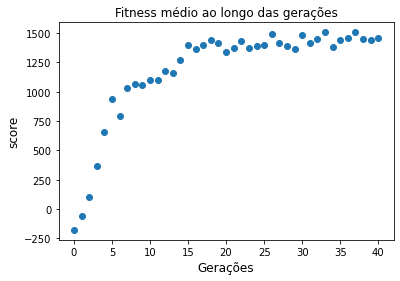

In [15]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

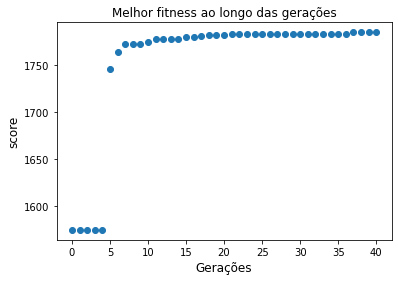

In [16]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

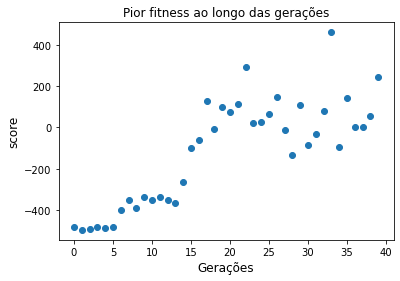

In [17]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, essa estabilização ocorreu perto da geração 20. O maior fitness ao longo das gerações subiu abruptamente na geração 5 e atingiu um valor limite na geração 15. O pior fitness ao longo das gerações também subiu, mas não tanto, além disso é possivél ver que em algumas gerações obtive que o pior fitness foi maior do que a maioria, mas se analisarmos bem é possível notar que também a partir da geração 20 os valores foram se estabilizando.<br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o que acontece com o score:
</p>

In [15]:
melhor_individuo = model.best_solution[0]
runNtimes('smallClassic', melhor_individuo, 10)

Score: 1168.0 - pacman venceu com 244 movimentos
Score: 1569.0 - pacman venceu com 241 movimentos
Score: 1562.0 - pacman venceu com 262 movimentos
Score: 1174.0 - pacman venceu com 226 movimentos
Score: 1565.0 - pacman venceu com 253 movimentos
Score: 1570.0 - pacman venceu com 238 movimentos
Score: 93.0 - pacman morreu com 109 movimentos
Score: 1574.0 - pacman venceu com 226 movimentos
Score: 1368.0 - pacman venceu com 244 movimentos
Score: 1780.0 - pacman venceu com 208 movimentos


<p style="text-align: justify;">
&emsp; Nessa minha execução o pacman foi ótimo, obtive 90% de vitória, e um score médio de 1342, o que é muito bom para esse layout. <br>
</p>

&emsp;Vou fazer algumas execuções com a interface gráfica para dar um exemplo:

In [18]:
melhor_individuo = model.best_solution[0]
game = runGame(melhor_individuo, 'smallClassic', graphics = True)

&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/smallClassic.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Nessa execução é possível perceber que os pesos estão bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o meu modelo e a aplicação do algoritmo genético foi um sucesso para esse layout, eu executei algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado.
</p>

#### 3.5 Layout MediumlClassic
&emsp; Agora vou definir a função de fitness para o layout mediumClassic, que retornará o score da partida e irá definir 2 fantasmas com comportamento aleatório, e note que irei usar o meu agente que criei no tópico 1.3:

In [5]:
def fitfunctionMediumClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'mediumClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    score = res[0].state.getScore() 

    return score

&emsp; Agora, vou utilizar os parâmetros e critérios que defini no tópico 3.1 para instanciar um modelo de algoritmo genético para pesos reais da biblioteca:

In [6]:
import geneticalgsmod as ge

modelMediumClassic = ge.RealGA(fitness_func = fitfunctionMediumClassic, 
                              optim='max',          #Irei maximizar o score
                              selection="rank",     #Para Seleção usarei o ranqueamento
                              mut_prob=0.10,        #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,           #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,       #Prob de ocorrer cross de 90%
                              cross_type=1,         #Cross singlepoint
                              elitism=True,         #Elitismo ativado
                              tournament_size=None)

&emsp; Vou iniciar uma população de 70 indivíduos e especificar que um indivíduo tem 7 genes no intervalo de [0,100]:

In [7]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,100)
modelMediumClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [8]:
max_generation = 40
fitness_progressMC, best_individualMC, worst_individualMC = modelMediumClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada
Geração 36 terminada
Geração 37 terminada
Geração 38 terminada
Geração 39 terminada
Geração 40 terminada


&emsp; Agora, como dito anteriormente, vou serializar os objetos para poder usar depois, irei colocar todas as saídas úteis em uma lista, irei serializar essa lista e salvar na pasta de nome save.

In [9]:
lista = [fitness_progressMC, best_individualMC, worst_individualMC, modelMediumClassic]
serialize(sys.path[0]+'/save/mediumClassicData', lista)

&emsp; Agora vou desserializar a lista e restaurar o progresso do treinamento:

In [10]:
lista = deserialize(sys.path[0]+'/save/mediumClassicData')

&emsp; Definindo novamente as variaveis:

In [11]:
fitness_progress, best_individual, worst_individual, model = lista

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

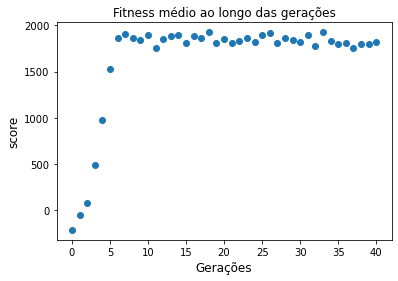

In [12]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

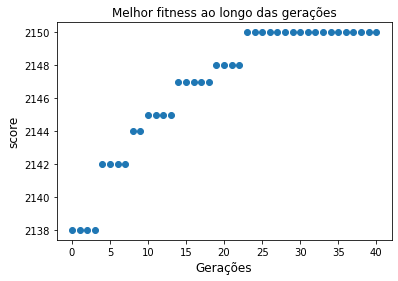

In [13]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

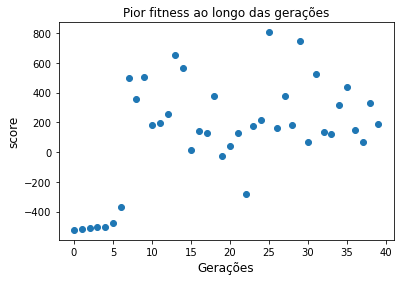

In [14]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, essa estabilização ocorreu perto da geração 5. O maior fitness ao longo das gerações foi subinda progressivamente, mas note que o score já começou alto . O pior fitness ao longo das gerações também subiu, os pontos ficaram baguncados depois da geração 10,mas pode-se notar que eles se concentraram em um intervalo.<br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o que acontece com o score:
</p>

In [15]:
melhor_individuo = model.best_solution[0]
runNtimes('mediumClassic', melhor_individuo, 10)

Score: 1722.0 - pacman venceu com 442 movimentos
Score: 1530.0 - pacman venceu com 418 movimentos
Score: 1930.0 - pacman venceu com 418 movimentos
Score: 1727.0 - pacman venceu com 427 movimentos
Score: 2136.0 - pacman venceu com 400 movimentos
Score: 2128.0 - pacman venceu com 424 movimentos
Score: 686.0 - pacman morreu com 251 movimentos
Score: 1922.0 - pacman venceu com 442 movimentos
Score: 2122.0 - pacman venceu com 442 movimentos
Score: 1737.0 - pacman venceu com 397 movimentos


<p style="text-align: justify;">
&emsp; Nessa minha execução o pacman foi ótimo, obtive 90% de vitória, e um score médio de 1764, o que é muito bom para esse layout. <br>
</p>

&emsp;Vou fazer algumas execuções com a interface gráfica para dar um exemplo:

In [17]:
melhor_individuo = model.best_solution[0]
game = runGame(melhor_individuo, 'mediumClassic', graphics = True)

&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/mediumClassic.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Assim como na execução para o outro layout, é possível perceber que os pesos estão bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o meu modelo e a aplicação do algoritmo genético foi um sucesso para esse layout. <br>
&emsp; Da mesma forma que fiz para o layout anterior, eu executei algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado. Ele não se suicida para tentar comer algum elemento do mapa.<br>
</p>

#### 3.6 Layout OriginalClassic
<p style="text-align: justify;">
&emsp; Agora vou definir a função de fitness para o layout originalClassic.<br>
&emsp; Para esse layout farei diferente, como esse layout é maior e os fantasmas são aleatórios, é mais fácil um individuo completar o jogo porque teve sorte, e não porque seus conjunto de pesos está bem calibrado.<br>
&emsp; Sabendo disso, a função de fitness não retornará apenas o score de um jogo, mas agora retornará o score médio da execução de 3 jogos:
</p>

In [8]:
def fitfunctionOriginalClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'originalClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 3
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 8
    
    res = runGames(**argumentos)
    scores = [game.state.getScore() for game in res]
    avgScore = sum(scores) / float(len(scores))
     
    return avgScore

<p style="text-align: justify;">
&emsp; Agora, vou utilizar os parâmetros e critérios que defini no tópico 3.1 para instanciar um modelo de algoritmo genético para pesos reais da biblioteca, mas vou fazer duas mudanças, pelo mesmo motivo que mudei a função de fitness, vou aumentar a probabilidade de mutação para 15% e a população inicial para 100 indivíduos, isso tudo para evitar a estocacidade do jogo, que aumentou junto com o tamanho do tabuleiro.
</p>

In [9]:
import geneticalgsmod as ge

modelOriginalClassic = ge.RealGA(fitness_func = fitfunctionOriginalClassic, 
                              optim='max',          #Irei maximizar o score
                              selection="rank",     #Para Seleção usarei o ranqueamento
                              mut_prob=0.15,        #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,           #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,       #Prob de ocorrer cross de 90%
                              cross_type=1,         #Cross singlepoint
                              elitism=True,         #Elitismo ativado
                              tournament_size=None)

&emsp; Vou iniciar uma população de 100 indivíduos e especificar que um indivíduo tem 7 genes no intervalo de [0,500]:

In [11]:
population_size = 100
dimensao = 7         # numero de argumentos da funcao        
interval = (0,500)
modelOriginalClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [12]:
max_generation = 30
fitness_progressOC, best_individualOC, worst_individualOC = modelOriginalClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada


&emsp; Agora, como dito anteriormente, vou serializar os objetos para poder usar depois, irei colocar todas as saídas úteis em uma lista, irei serializar essa lista e salvar na pasta de nome save.

In [13]:
lista = [fitness_progressOC, best_individualOC, worst_individualOC, modelOriginalClassic]
serialize(sys.path[0]+'/save/originalClassicData', lista)

&emsp; Agora vou desserializar a lista e restaurar o progresso do treinamento:

In [14]:
lista = deserialize(sys.path[0]+'/save/originalClassicData')

&emsp; Definindo novamente as variaveis:

In [15]:
fitness_progress, best_individual, worst_individual, model = lista

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

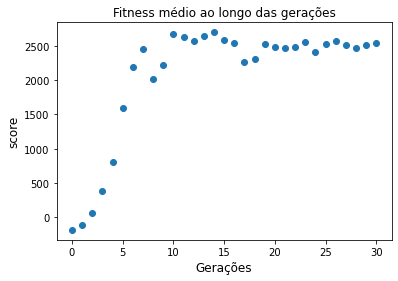

In [16]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

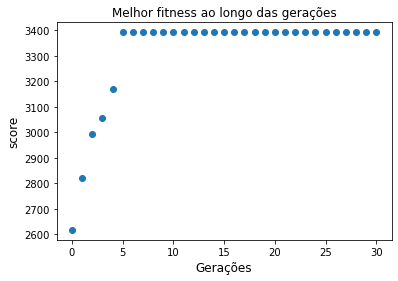

In [17]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

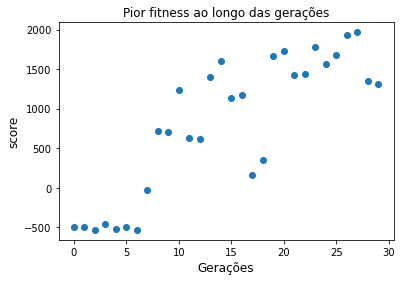

In [18]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, essa estabilização ocorreu perto da geração 10. O maior fitness ao longo das gerações foi subindo progressivamente e atingiu um valor limite na geração 5, mas note que o score já começou alto. O pior fitness ao longo das gerações também subiu, os pontos ficaram bagunçado, mas pode-se notar que eles se concentraram em um intervalo e subiram com um padrão.<br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o que acontece com o score:
</p>

In [21]:
melhor_individuo = model.best_solution[0]
runNtimes('originalClassic', melhor_individuo, 10)

Score: 2652.0 - pacman venceu com 1012 movimentos
Score: 2693.0 - pacman venceu com 889 movimentos
Score: 2839.0 - pacman venceu com 1051 movimentos
Score: 2669.0 - pacman venceu com 961 movimentos
Score: 3052.0 - pacman venceu com 1012 movimentos
Score: 2441.0 - pacman venceu com 1045 movimentos
Score: 2856.0 - pacman venceu com 1000 movimentos
Score: 2848.0 - pacman venceu com 1024 movimentos
Score: 2857.0 - pacman venceu com 997 movimentos
Score: 2865.0 - pacman venceu com 973 movimentos


<p style="text-align: justify;">
&emsp; Nessa minha execução o pacman foi ótimo, obtive 100% de vitória, e um score médio de 2777, o que é muito bom para esse layout. <br>
</p>

&emsp;Vou fazer algumas execuções com a interface gráfica para dar um exemplo:

In [22]:
melhor_individuo = model.best_solution[0]
game = runGame(melhor_individuo, 'originalClassic', graphics = True)

&emsp; Como não consigo colocar a execução no notebook vou colocar um video de uma execução:

In [23]:
from IPython.display import HTML

HTML("""
    <video width="500" height="400" controls style ="display:block; margin:0 auto;">
        <source src="gifs/OriginalClassic.mp4" type="video/mp4">
    </video>
""")

<p style="text-align: justify;">
&emsp; Como visto nessa execução, o pacman não persegue muito os fantasmas assustados, apenas quando estão próximos, se ele perseguisse muito os fantasmas assustados o score aumentaria bastante. <br>
&emsp; Diferentemente dos outros layouts, o pacman não perseguiu tanto os pacmans, isso aconteceu, provavelmente, porque o layout é muito grande e existem apenas dois fantasmas, assim era mais facil um pacman obter um score alto por sorte. <br>
&emsp; Então, talvez o meu modelo precisasse de um treinamento com uma população inicial maior, para obter maior variabilidade genética, porém o resultado demoraria bastante para sair, nesse ultimo layout, da maneira que fiz, o resultado demorou aproximadamente 16 horas para sair a resposta. <br>
&emsp; Apesar desse fato, o treinamento foi bem sucedido, a taxa de vitória é extremamente alta, nas 10 execuções que fiz, tive 100% de vitória, o pacman consegue fugir muito bem dos fantasmas e perseguir os fantasmas assustados quando estão próximos.
</p>

### 4. Conclusão
<p style="text-align: justify;">
&emsp; A partir dos resultados obtidos é possível notar que a aplicação do algoritimo genético foi um sucesso, o pacman obteve uma taxa de vitória alta para os 3 layouts e um score médio alto também, isso prova que tanto o modelo que desenvolvi para se aplicar o algoritimo genético, quanto a própria metodologia adota foram adequadas para a resolução do problema.<br>
</p>

# Parte 2

<p style="text-align: justify;">
&emsp; Nesta parte do projeto vou aplicar uma técnica de aprendizado por reforço para resolver o problema do Pac-man. O trabalho consiste em encontrar uma solução adequada para o problema, avaliando-o segundo diversos parâmetros.<br>
&emsp; A primeira coisa que preciso fazer é definir um método de aprendizado por reforço para resolver o problema, no tópico a seguir irei defini-lo e explica-lo.
</p>


### 1. Definição do método
<p style="text-align: justify;">
&emsp; Inicialmente devemos concordar que o problema do pacman segue um MDP (Markov Decision Process), isso porque a tomada de decisões do pacman envolvem situações em que o estado do jogo é parcialmente aleatórios e parcialmente sob o controle de um tomador de decisão. <br>
&emsp; Vou definir termos importantes para o nosso MDP:<br>
&emsp; - Estado: Todas as configurações possíveis no jogo, incluindo as posições das comidas, as posições do fantasmas, posições do pacman, etc. <br>
&emsp; - Ações: Um conjunto de todas as ações permitidas do pacman, isso inclui ele ficar parado, ir para cima, para baixo, para esquerda, ou para direita. <br>
&emsp; - Política: Um mapeamento do estado para as ações do pacman. <br>  
&emsp; Sabendo disso, vou escolher como método o "Q-learning with function approximation", para entendelo, primeiro precisamos entender o Q-learning convencional: <br>
</p>

#### 1.1 Q-learning
<p style="text-align: justify;">
&emsp; O Q -learning é um algoritmo de aprendizado por reforço sem modelo para aprender o valor de uma ação em um estado particular. Ele não requer um modelo do ambiente e pode lidar com problemas com transições estocásticas e recompensas sem exigir adaptações. <br>
&emsp; O algoritmo desse método tem uma função que calcula a qualidade de uma combinação estado-ação, antes de começar a aprender, Q é inicializado com um valor fixo e arbitrário. Então, a cada instante $t$ o agente seleciona uma ação $a$, observa uma recompensa $r$, entra em um novo estado $s'$ e Q é atualizado através da seguinte expressão:<br>
    $$Q(s,a) \gets Q(s,a) + \alpha \cdot(r + \gamma\cdot \underset{a'}{\max}Q(s',a') - Q(s,a) )$$
&emsp; $\alpha$ é a taxa de aprendizagem, ela determina em que medida as informações recém-adquiridas substituem as informações antigas. <br>
&emsp; $\gamma$ é o fator de desconto, ele determina a importância das recompensas futuras. Um fator de 0 considerará apenas as recompensas atuais, enquanto um fator próximo a 1 fará com que se esforce por uma alta recompensa a longo prazo.<br>
&emsp; $r$ é a recompensa ganhar pela ação. <br>
&emsp; No pacman, o objetivo do jogador é obter uma série de ótimas ações para maximizar a recompensa total que poderia obter no fim do jogo.<br>
&emsp; Os valores Q são aprendidos iterativamente, atualizando a estimativa do valor Q atual para a recompensa observada.
</p>

#### 1.2 Q-learning with function approximation / Approximate Q-learning 
<p style="text-align: justify;">
&emsp; No jogo do pacman existem muitos estados para visitar e explorar, e isso é um problema, porque o Q-Learning convencional não conseguirá explorar todos os estados possíveis. Então, por questão de escalabilidade, precisamos fazer algo mais genérico, para isso podemos ver o que aprendemos sobre os estados já visitados e generalizá-los para novos estados semelhantes, para fazer isso pode-se usar uma função de aproximação, podendo usar features para representar os estados visitados. <br>
&emsp; O que foi dito no paragráfo anterior é a ideia por trás do Q-learning with function approximation, nele $Q(s,a)$ é obtido por uma combinacao linear das features do estado $f_i(s,a)$, da seguinte forma:
                            $$Q(s,a;w) = \sum_{i=1}^n f_i(s,a)\cdot w_i$$
&emsp; O agente pacman terá que aprender os pesos através das features extraidas do estado do jogo, os pesos são atualizados da seguinte forma:   
        $$w_i \gets w_i + \alpha \cdot(r + \gamma\cdot \underset{a'}{\max}Q(s',a') - Q(s,a)) \cdot f_i(s,a)$$
&emsp; Dessa forma, o pacman não precisará visitar todos os estados possíveis do jogo, já que agora é possível aproximar o que já foi aprendido em um estado. <br>

#### 1.3 Política Epsilon-Greedy
<p style="text-align: justify;">
&emsp; Uma política gulosa é aquela em que a ação do agente será a melhor possível dentro do modelo, no meu caso, será aquela que possuir maior valor de $Q(s,a;w)$. <br>
&emsp; Já uma política Epsilon-Greedy, segue uma lógica parecida, porém agora existe uma probabilidade na escolha da ação do agente. Isso é, existe uma probabilidade $\epsilon$ de ocorrer uma ação aleatória, e uma probabilidade $1 - \epsilon$ de a ação do agente ser a melhor possível dentro do modelo. <br>
&emsp; No meu caso utilzarei a Epsilon-Greedy, essa política é boa porque incentiva o agente, no meu caso o pacman, a explorar uma variedade maior de estados e assim conseguir aproximar um número maior de estados no Q-Learning com função de aproximação.<br>
</p>

### 2. Implementações
<p style="text-align: justify;">
&emsp; Nesse tópico farei a implementação de um agente do pacman que implementa o Q-Learning com função de aproximação e uma classe para extrair as features do jogo, mas primeiro irei definir as dependencias:<br>

#### 2.1 Dependências
<p style="text-align: justify;">
&emsp; Abaixo vou fazer os imports necessarios da engine do pacman:
</p>

In [1]:
import sys, os
os.chdir(sys.path[0]+'/search')

from pacman import runGames, loadAgent
from pacman import Directions
import pacmanAgents
from util import Queue
import textDisplay
import game
import layout
import random
import util
import graphicsDisplay
from game import *

import random
import numpy as np

#### 2.2 Extrator de features
<p style="text-align: justify;">
&emsp; Para o Q-Learning com função de aproximação utilizarei as seguintes features:

1) Distancia do pacman à comida mais próxima.
2) Número de fantasmas não assustados na posição seguinte.
3) Distancia do pacman ao fantasma assustado mais próximo.
4) Número de fantasmas assustados em até duas posições de distancia.  
5) Número de fantasmas não assustados em até duas posições de distancia.
6) Distancia do pacman à capsula mais próxima.
7) Número de capsulas, se existir fantasmas não assustados.
8) Três features para estimular o pacman ir atrás da comida, das capsulas e dos fantasmas assustados, quando não ha fantasmas não assustados proximos.
9) Uma feature de bias.

&emsp; Abaixo vou definir uma classe Features, essa classe terá um método getFeatures, que retornará as features que planejei acima:

In [2]:
class Features:
    
    def getNeighbors(self, pos, walls, visited):
        c, l = pos
        neighbors = []
        
        for i in range(-1,2,1):
            for j in range(-1,2,1):
                if(abs(i) != abs(j) and c+i < walls.width and c+i >= 0 and l+j < walls.height and l+j >= 0):
                    if(walls[c+i][l+j] == False and visited[c+i][l+j] == 0):
                        neighbors.append((c+i,l+j))             
        return neighbors
        
    def bfsDistance(self, state, posIni, endPos = None, food = False):
        queue = Queue()
        
        walls = state.getWalls()
        if(food):
            foods = state.getFood()
            
        visited = np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]] = 1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current = queue.pop()
            pos = current[0]
            stepsUntilNow = current[1]
            
            if(food == True):
                if(foods[pos[0]][pos[1]] == True):
                    return stepsUntilNow
            else:
                if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                    return stepsUntilNow
    
            visited[pos[0]][pos[1]] = 1
            possibles = self.getNeighbors(pos,walls, visited)
            for possibleMove in possibles:
                queue.push((possibleMove, stepsUntilNow+1))
        return -1
    
    def ghosts(self, state):
        ghostsPos = state.getGhostPositions()
        n_ghosts = len(ghostsPos)
        
        scared_timer = []
        positionsNonScared = []
        positionsScared = []
        
        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                positionsNonScared.append(np.ceil(ghostsPos[i]))
            else:
                positionsScared.append(np.ceil(ghostsPos[i]))
            
        return positionsScared, positionsNonScared
    
    def nearstElement(self, state, posElement, pacmanPos):
        minDist = float('inf')
        for pos in posElement:
            dist = self.bfsDistance(state, pacmanPos, pos)
            if(dist < minDist):
                minDist = dist
        return minDist
    
    def getFeatures(self, state, action):
        features = util.Counter()
        
        # Extrai do grid posicoes dos elementos
        food = state.getFood()
        walls = state.getWalls()
        scaredGhosts, badGhosts = self.ghosts(state)
        capsules = state.getCapsules() 

        features["bias"] = 1.0
        
        # Computa a posicao do pacman após executar a acao
        x, y = state.getPacmanPosition()
        dx, dy = Actions.directionToVector(action)
        next_x, next_y = int(x + dx), int(y + dy)
        pacman = (next_x, next_y)
        
        ############## Closest food distance #################
        dist = self.bfsDistance(state, pacman, food = True)
        if (dist > 0):
            features["closest-food"] = float(dist)/(walls.width * walls.height)

        ############# Number of bad ghosts one step away ###########
        if(len(badGhosts) > 0):
            features["badghosts-one-step"] = sum(pacman in Actions.getLegalNeighbors(g, walls) for g in badGhosts)

        ############### Distance to closest scared ghost ################
        if(len(scaredGhosts) > 0):
            distScaredGhosts = self.nearstElement(state, scaredGhosts, pacman)
            if (distScaredGhosts > 0):
                features["closest-scared"] = float(distScaredGhosts)/(walls.width * walls.height)
        
        ############ Number of scared ghosts 2 steps away ###############
        if(len(scaredGhosts) > 0):
            num = 0
            for ghost in scaredGhosts:
                distance = self.bfsDistance(state, pacman, ghost)
                if(distance > 0 and distance <= 2):
                    num += 1
            features["scared-two-step"] = num 
        
        ############ Number of bad ghosts 2 steps away ###############
        if(len(badGhosts) > 0):
            num = 0
            for ghost in badGhosts:
                distance = self.bfsDistance(state, pacman, ghost)
                if(distance > 0 and distance <= 2):
                    num += 1
            features["bad-two-step"] = num
            
        ############## Minimum distance to a capsule #################
        if(len(capsules) > 0):
            distCapsule = self.nearstElement(state, capsules, pacman)
            if (distCapsule > 0):
                features["closest-capsule"] = float(distCapsule)/(walls.width * walls.height)
        
        ########### Activation of number of capsules when bad ghosts #############
        if(len(capsules) > 0 and len(badGhosts) > 0):
            features["num-capsules"] = len(capsules)

        ########### Activation of features when ghost is not nearby #############
        if(not features["badghosts-one-step"] and not features["bad-two-step"]):
            if(len(scaredGhosts) > 0):
                features["scar"] = 4.0
            elif(len(capsules) > 0):
                features["cap"] = 2.0
            elif(food[next_x][next_y]):
                features["food"] = 1.0

        features.divideAll(10.0)
        return features


<p style="text-align: justify;">
&emsp; O método do getFeatures dessa classe retorna as features que havia planejado anteriormente, note que para  cálcular as distancias e elementos mais próximos eu aproveitei os métodos já implementados que usei no agente para o algoritmo genético. <br>
&emsp; Note que as três features para estimular o pacman ir atrás da comida, das capsulas e dos fantasmas assustados iniciaram com pesos diferentes valendo 1, 2 e 4, respectivamente, fiz isso porque o pacman deve seguir em termos de importância primeiro os fantamas assustados, se existirem, depois as capsulas e por fim as comidas, isso garantirá um score maior. Se todos esses valores começarem com o mesmo valor o Q-Learning daria conta de calibrar os pesos corretamente, porém vou fazer isso para facilitar a convergência, ou seja, vou incentivar o QLearning a achar os pesos mais rapidamente, e mesmo que eu esteja errado o Q-Learning irá ajustar os pesos e provavelmente o modelo convergirá da mesma forma. <br>
</p> 

#### 2.3 Q-Learning with function approximation
<p style="text-align: justify;">
&emsp; Agora vou definir um agente do pacman que já implementa um Q-Learning com função de aproximação e que usa uma política epsilon-greedy, segue abaixo o código:
</p>

In [3]:
class QAgent(Agent):
    
    def __init__(self, alpha = 0.1, epsilon = 0, gamma=0.5, numTraining = 100):
        self.alpha = float(alpha)
        self.epsilon = float(epsilon)
        self.discount = float(gamma)
        
        self.numTraining = int(numTraining)
        
        self.episodes = 0
        
        self.prev_state = None
        self.prev_action = None
        self.prev_score = None
        
        self.weights = util.Counter()
        self.features = Features()
    
    def getAction(self, state):        
        # Update weights
        if(self.prev_state != None):
            reward = state.getScore() - self.prev_score
            self.update_weigths(self.prev_state, self.prev_action, state, reward)

        # Update state
        self.update_state(state)
        
        return self.prev_action
   
    def getQValue(self, state, action):
        QValue = 0
        features = self.features.getFeatures(state, action)
        for feature in features:
            QValue += features[feature] * self.weights[feature]
        return QValue
    
    def maxQValue(self, state):
        qvalues = [self.getQValue(state, action) for action in state.getLegalPacmanActions()]
        if not len(qvalues):
            return 0
        return max(qvalues)
    
    def update_weigths(self, state, action, nextState, reward):
        features = self.features.getFeatures(state, action)
        difference = reward + self.discount * self.maxQValue(nextState) - self.getQValue(state, action)
        for feature in features:
            self.weights[feature] += self.alpha * difference * features[feature]
    
    def update_state(self, state):
        self.prev_state = state
        self.prev_action = self.epsilonGreedy(state)
        self.prev_score = state.getScore()
    
    def epsilonGreedy(self, state):
        legalActions = state.getLegalPacmanActions()
        if not len(legalActions):
            return None
        probability = random.random()
        if probability < self.epsilon:
            random_action = random.choice(legalActions)
            return random_action
        QValue = float('-inf')
        for legalAction in legalActions:
            QValueTemp = self.getQValue(state, legalAction)
            if QValueTemp > QValue:
                action = legalAction
                QValue = QValueTemp
        return action
    
    def reset_state(self):
        self.prev_state = None
        self.prev_action = None
        self.prev_score = None

    def final(self, state):
        # update weights
        if self.prev_state != None:
            reward = state.getScore() - self.prev_score
            self.update_weigths(self.prev_state, self.prev_action, state, reward)
        
        # Reset state from current game
        self.reset_state()
        
        self.episodes += 1
        if(self.episodes%100 == 0 and self.episodes <= self.numTraining):
            print("Já foi rodado",self.episodes,"episódios de treino, faltam",self.numTraining-self.episodes)
        if self.episodes == self.numTraining:
            self.alpha = 0
            self.epsilon = 0

<p style="text-align: justify;">
&emsp; Vamos analisar como o código funciona, primeiro vou apresentar os parâmetros dessa classe, nela é esperado um valor epsilon para aplicar a política epsilon-greedy, também é esperado um alpha, que é a taxa de aprendizado, e um gamma, que é o disconto que é usado no Q-Learning, todos esses parâmetros já foram discutidos anteriormente. <br>
&emsp; Quando o jogo é rodado, sempre que é esperado que o pacman faça uma ação é chamado o método getAction do agente. Sabendo disso, no meu agente, quando ele é chamado a primeira coisa que é feita é atualizar os pesos do approximate Q-Learning, usando o método update_weigths, observe que os pesos das features são atualizados conforme explicado no tópico 1.2, e note que a recompensa é a diferença entre o score do estado atual e do estado anterior. <br>
&emsp; Após isso, os atributos da classe que salvam o estado, o score anterior e a ultima ação do pacman são atualizados, a ação é computada usando a política epsilon-greedy, que também ja foi explicada. Então essa ação é retornada pelo getAction. <br>
&emsp; Isso se repete até que a partida termina, quando isso acontece o próprio jogo chama o método final do agente, nesse meu método eu atualizo os pesos em relação a ação final do pacman, e então os atributos que se referem a partida atual são resetados. Observe que quando o número atual de episódios atingir o número de treinamentos o valor de alfa e epsilon são zerados, isso acontece porque quando o jogo está rodando fora do treinamento, ou seja estamos em um jogo "pra valer", não queremos que o pacman aprenda ou explore o tabuleiro. <br>

### 3. Treinamento
<p style="text-align: justify;">
&emsp; Antes de dar detalhes sobre como farei o treinamento, primeiro vou implementar algumas funções que irão me auxilizar:<br>

#### 3.1 Funções auxiliares
<p style="text-align: justify;">
&emsp; A primeira função que vou fazer é uma que, dado o valor de alfa, epsilon, gama e o número de jogos para treinamento, roda o jogo com dois fantasmas aleatórios, em um layout especifico e retorna o agente treinado:
</p>

In [4]:
def trainingQLearn(alpha, epsilon, gamma, numTraining, olayout):
    argumentos ={}
    pacman = QAgent(alpha, epsilon, gamma, numTraining)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout(olayout)
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = numTraining
    argumentos['numTraining'] = numTraining
    argumentos['record'] = False
    argumentos['catchExceptions'] = False
    runGames(**argumentos)
    return pacman

<p style="text-align: justify;">
&emsp; A próxima função é uma que dado o agente, já treinado, o e o layout, o pacman será rodado n vezes e imprimirá o score, se o pacman ganhou ou perdeu e número de movimentos:
</p>

In [5]:
def runNgames(pacman, olayout, n, graphics = False):
    argumentos ={}
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout(olayout)
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    if(graphics):
        argumentos['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
    argumentos['numGames'] = n
    argumentos['catchExceptions'] = False
    argumentos['record'] = False
    
    res = runGames(**argumentos)

    for game in res: 
        if(game.state.isWin()):
            status = 'pacman venceu'
        else:
            status = 'pacman morreu'
        n = len(game.moveHistory)
        print('Score:', game.state.getScore(),'-', status, 'com', n, 'movimentos')

#### 3.2 Layout smallClassic
<p style="text-align: justify;">
&emsp; Agora que já defini as funções que irei utilizar no treinamento, posso aplica-las nos meus layouts, primeiro irei treinar para o smallClassic.<br>
&emsp; Irei utilizar uma taxa de aprendizado alfa de 0.1, uma taxa de exploração, para o epsilon-greedy de 0.4, um valor gama do desconto, que irá impactar sobre decisões de longo prazo, valendo 0.6, além disso irei treinar por 1000 episódios. <br>
&emsp; Escolhi esse alfa porque valores muito grandes podem atrapalhar no aprendizado e fazer o pacman cair em um mínimo local, escolhi um valor epsilon médio, isso permitirá que o pacman explore bem o tabuleiro, e escolhi um gama alto, mas nem tanto, para ensinar ao pacman que certas ações podem impactar o score no futuro. <br>
&emsp; A seguir o treinamento: 
</p>

In [6]:
alpha = 0.1
epsilon = 0.4
gamma = 0.6
numTraining = 1000
olayout = "smallClassic"
trainedPacman = trainingQLearn(alpha, epsilon, gamma, numTraining, olayout)

Já foi rodado 100 episódios de treino, faltam 900
Já foi rodado 200 episódios de treino, faltam 800
Já foi rodado 300 episódios de treino, faltam 700
Já foi rodado 400 episódios de treino, faltam 600
Já foi rodado 500 episódios de treino, faltam 500
Já foi rodado 600 episódios de treino, faltam 400
Já foi rodado 700 episódios de treino, faltam 300
Já foi rodado 800 episódios de treino, faltam 200
Já foi rodado 900 episódios de treino, faltam 100
Já foi rodado 1000 episódios de treino, faltam 0


<p style="text-align: justify;">
&emsp; Agora que tenho um agente treinado vou executa-lo 10 vezes para ver como se comporta, vou mudar o epsilon e alpha do agente para zero, porque como já foi treinado não quero que ele aprenda ou explore o tabuleiro:
</p>

In [7]:
trainedPacman.alpha = 0
trainedPacman.epsilon = 0
runNgames(trainedPacman, "smallClassic", 10)            

Score: 1746.0 - pacman venceu com 310 movimentos
Score: 1751.0 - pacman venceu com 295 movimentos
Score: 1539.0 - pacman venceu com 331 movimentos
Score: 1747.0 - pacman venceu com 307 movimentos
Score: 1745.0 - pacman venceu com 313 movimentos
Score: 1534.0 - pacman venceu com 346 movimentos
Score: 1744.0 - pacman venceu com 316 movimentos
Score: 1768.0 - pacman venceu com 244 movimentos
Score: 1538.0 - pacman venceu com 334 movimentos
Score: 1753.0 - pacman venceu com 289 movimentos


<p style="text-align: justify;">
&emsp; O pacman foi excelente, obtive 100% de vitória e um score médio de 1686, o que é muito bom para esse layout. <br></p>

&emsp; Agora vou executar um jogo com interface gráfica para ver como ficou:

In [9]:
runNgames(trainedPacman, "smallClassic", 1, graphics = True)

Score: 1746.0 - pacman venceu com 310 movimentos


&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/smallClassicRL.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Nessa execução é possível perceber que os pesos do Q-Learning com função de aproximação foram bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o Q-Learning com função de aproximação foi um sucesso para esse layout, eu executei mais algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado.
</p>

#### 3.3 Layout mediumClassic
<p style="text-align: justify;">
&emsp; Aqui, irei utilizar os mesmos parametros que utilizei para o smallClassic, ou seja, uma taxa de aprendizado alfa de 0.1, uma taxa de exploração, para o epsilon-greedy de 0.4, um valor gama do desconto, que irá impactar sobre decisões de longo prazo, valendo 0.6, além disso irei treinar por 1000 episódios. <br>
&emsp; A seguir o treinamento: 
</p>

In [10]:
alpha = 0.1
epsilon = 0.4
gamma = 0.6
numTraining = 1000
olayout = "mediumClassic"
trainedPacmanMC = trainingQLearn(alpha, epsilon, gamma, numTraining, olayout)

Já foi rodado 100 episódios de treino, faltam 900
Já foi rodado 200 episódios de treino, faltam 800
Já foi rodado 300 episódios de treino, faltam 700
Já foi rodado 400 episódios de treino, faltam 600
Já foi rodado 500 episódios de treino, faltam 500
Já foi rodado 600 episódios de treino, faltam 400
Já foi rodado 700 episódios de treino, faltam 300
Já foi rodado 800 episódios de treino, faltam 200
Já foi rodado 900 episódios de treino, faltam 100
Já foi rodado 1000 episódios de treino, faltam 0


<p style="text-align: justify;">
&emsp; Agora que tenho um agente treinado vou executa-lo 10 vezes para ver como se comporta, vou mudar o epsilon e alpha do agente para zero, porque como já foi treinado não quero que ele aprenda ou explore o tabuleiro:
</p>

In [12]:
trainedPacmanMC.alpha = 0
trainedPacmanMC.epsilon = 0
runNgames(trainedPacmanMC, "mediumClassic", 10)            

Score: 2126.0 - pacman venceu com 430 movimentos
Score: 2121.0 - pacman venceu com 445 movimentos
Score: 2141.0 - pacman venceu com 385 movimentos
Score: 676.0 - pacman morreu com 400 movimentos
Score: 2121.0 - pacman venceu com 445 movimentos
Score: 496.0 - pacman morreu com 192 movimentos
Score: 2101.0 - pacman venceu com 505 movimentos
Score: 2105.0 - pacman venceu com 493 movimentos
Score: 2101.0 - pacman venceu com 505 movimentos
Score: 2107.0 - pacman venceu com 487 movimentos


<p style="text-align: justify;">
&emsp; O pacman foi muito bem, obtive 80% de vitória e um score médio de 1759, o que é bom para esse layout. <br></p>

&emsp; Agora vou executar um jogo com interface gráfica para ver como ficou:

In [13]:
runNgames(trainedPacmanMC, "mediumClassic", 2, graphics = True)

Score: 2138.0 - pacman venceu com 394 movimentos
Score: 2130.0 - pacman venceu com 418 movimentos


&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/mediumClassicRL.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Assim como para o smallClassim, nessa execução é possível perceber que os pesos do Q-Learning com função de aproximação foram bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o Q-Learning com função de aproximação também foi um sucesso para esse layout, aqui também executei mais algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado.
</p>

#### 3.4 Layout originalClassic
<p style="text-align: justify;">
&emsp; Nos outros layouts vimos que o método RL que estou utilizando está indo bem, portanto, para esse layout, também irei utilizar os mesmos parametros que utilizei para o smallClassic e mediumClassic, ou seja, uma taxa de aprendizado alfa de 0.1, uma taxa de exploração, para o epsilon-greedy de 0.4, um valor gama do desconto, que irá impactar sobre decisões de longo prazo, valendo 0.6, além disso irei treinar por 1000 episódios. <br>
&emsp; A seguir o treinamento: 
</p>

In [14]:
alpha = 0.1
epsilon = 0.4
gamma = 0.6
numTraining = 1000
olayout = "originalClassic"
trainedPacmanOC = trainingQLearn(alpha, epsilon, gamma, numTraining, olayout)

Já foi rodado 100 episódios de treino, faltam 900
Já foi rodado 200 episódios de treino, faltam 800
Já foi rodado 300 episódios de treino, faltam 700
Já foi rodado 400 episódios de treino, faltam 600
Já foi rodado 500 episódios de treino, faltam 500
Já foi rodado 600 episódios de treino, faltam 400
Já foi rodado 700 episódios de treino, faltam 300
Já foi rodado 800 episódios de treino, faltam 200
Já foi rodado 900 episódios de treino, faltam 100
Já foi rodado 1000 episódios de treino, faltam 0


<p style="text-align: justify;">
&emsp; Agora que tenho um agente treinado vou executa-lo 10 vezes para ver como se comporta, vou mudar o epsilon e alpha do agente para zero, porque como já foi treinado não quero que ele aprenda ou explore o tabuleiro:
</p>

In [15]:
trainedPacmanOC.alpha = 0
trainedPacmanOC.epsilon = 0
runNgames(trainedPacmanOC, "originalClassic", 10)            

Score: 3993.0 - pacman venceu com 1189 movimentos
Score: 3404.0 - pacman venceu com 1156 movimentos
Score: 2114.0 - pacman morreu com 1096 movimentos
Score: 3578.0 - pacman venceu com 1234 movimentos
Score: 3366.0 - pacman venceu com 1270 movimentos
Score: 3157.0 - pacman venceu com 1297 movimentos
Score: 3733.0 - pacman venceu com 1369 movimentos
Score: 2136.0 - pacman morreu com 940 movimentos
Score: 3749.0 - pacman venceu com 1321 movimentos
Score: 3604.0 - pacman venceu com 1156 movimentos


<p style="text-align: justify;">
&emsp; O pacman foi muito bem, obtive 80% de vitória e um score médio de 3283, o que é bom para esse layout. <br></p>

&emsp; Agora vou executar um jogo com interface gráfica para ver como ficou:

In [17]:
runNgames(trainedPacmanOC, "originalClassic", 2, graphics = True)

Score: 3327.0 - pacman venceu com 1387 movimentos
Score: 3405.0 - pacman venceu com 1153 movimentos


&emsp; Como não consigo colocar a execução no notebook vou colocar um vídeo de uma execução:

In [18]:
from IPython.display import HTML

HTML("""
    <video width="500" height="400" controls style ="display:block; margin:0 auto;">
        <source src="gifs/OriginalClassicRL.mp4" type="video/mp4">
    </video>
""")

<p style="text-align: justify;">
&emsp; Assim como para o smallClassim e mediumClassic, nessa execução é possível perceber que os pesos do Q-Learning com função de aproximação foram bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o Q-Learning com função de aproximação também foi um sucesso para esse layout, aqui também executei mais algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado.
</p>

### 4. Conclusão
<p style="text-align: justify;">
&emsp; A partir dos resultados obtidos é possível notar que a aplicação da aprendizagem por reforço foi um sucesso, o pacman obteve uma taxa de vitória alta para os 3 layouts e um score médio alto também, isso prova que o uso do approximate Q-Learning é uma solução adequada para o problema do pacman.<br>
&emsp; Quando comparado ao modelo evolucionario obtido na parte 1 desse projeto, o modelo por reforço, provou ser mais adequado, isso porque o modelo por reforço conseguiu um score médio consideravelmente alto em relação ao modelo evolucionario, sendo que a taxa de vitória foi parecida para os dois modelos em cada layout. <br>
&emsp; Uma outra diferença, é que para se obter o modelo por reforço foi necessario executar o pacman um número muito menor de vezes do que no modelo evolucionario. Nos layouts smallClassic e mediumClassic foram rodadas 40 gerações de 70 individuos, ou seja, 2800 execuções do pacman, enquanto no modelo por reforço esses layouts foram treinados por 1000 episódios, ou seja, 1000 execuções do pacman, quase 3 vezes menos execuções. No layout originalClassic também foram rodadas 40 gerações de 70 individuos, mas agora um individuo é o score médio de 3 execuções, o que da no total 8400 execuções do pacman, enquanto que no modelo por reforço foram usadas apenas 1000 execuções do pacman, quase 8 vezes menos execuções.<br>
&emsp; Ou seja, mesmo que o modelo por reforço tenha sido obtido a partir de um menor número de execuções do pacman ele obteve um resultado melhor, isso porque o score médio foi maior e a taxa de vitória foi parecida em relação ao modelo evolucionario. Isso acontece porque no jogo do pacman existe uma estocacidade envolvida nos fantasmas, e isso é um problema para a execução de um algorimo evolucionario, isso porque ao longo das gerações pode ser passado adiante individuos que obtiveram um score alto apenas porque teve sorte, o que torna a convergência desse tipo de métodologia mais lenta, porém ainda valida, já que ainda é possível se obter resultados bons através de um modelo evolucionario. <br>
</p>